## Rod Control Example

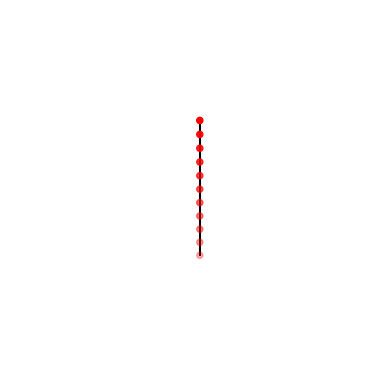

In [1]:
import numpy as np
import time
import dismech

geom = dismech.GeomParams(
    rod_r0=2e-2,
    shell_h=0.0,
)

material = dismech.Material(density=2000,
                            youngs_rod=1e3,
                            youngs_shell=0,
                            poisson_rod=0.5,
                            poisson_shell=0)

dynamic_2d_sim = dismech.SimParams(static_sim=True,
                                  two_d_sim=True,   # no twisting
                                  use_mid_edge=False,
                                  use_line_search=False,
                                  show_floor=False,
                                  log_data=True,
                                  log_step=1,
                                  dt=1e-2,
                                  max_iter=25,
                                  total_time=1,
                                  plot_step=1,
                                  tol=1e-4,
                                  ftol=1e-4,
                                  dtol=1e-2)

env = dismech.Environment()
env.add_force('gravity', g=np.array([0.0, 0.0, -20]))
env.add_force('damping', eta=10)

geo = dismech.Geometry.from_txt(
    '../tests/resources/rod_cantilever/vertical_rod_n11.txt')

robot = dismech.SoftRobot(geom, material, geo, dynamic_2d_sim, env)

## Reference configuration from csv

In [2]:
import numpy as np

# Path to your CSV file
ref_path = "vertical_rod_n11_reference.csv"

# Read the file (comma-separated, no header)
r_ref = np.loadtxt(ref_path, delimiter=",")

# r_ref: (N_nodes,3)

nodes_ind = robot.stretch_springs.nodes_ind     # (N_edges, 2)
L0        = robot.stretch_springs.ref_len       # (N_edges,)

p0 = r_ref[nodes_ind[:,0]]
p1 = r_ref[nodes_ind[:,1]]
Lref = np.linalg.norm(p1 - p0, axis=1)
eps_ref = Lref / L0 - 1.0                       # target strain per edge



In [3]:
print(eps_ref)

[0.     1.6677 1.4715 1.2753 1.0791 0.8829 0.6867 0.4905 0.2943 0.0981]


In [4]:
fixed_points = np.array([0, 1])

robot = robot.fix_nodes(fixed_points)
stepper = dismech.ImplicitEulerTimeStepper(robot)

### Time Stepping
PID Control

In [5]:
from dismech.controllers.longitudinalPI import LongitudinalPI

Kp = 5
Ki = 1
Kd = 0.01

nat0 = robot.stretch_springs.nat_strain.copy()  # shape (N_edges,)
pid  = LongitudinalPI(eps_ref, nat0, Kp=Kp, Ki=Ki, Kd=Kd,
                        du_rate=0.02, smooth_alpha=0.10)

dt = dynamic_2d_sim.dt
stretch_energy = None
pos_errors = []
strain_errors = []

def before_step_fn(rb, t):
    # fetch StretchEnergy from the stepper on every call (cheap)
    se = stepper.elastic_energies['stretch']

    # 1) measure current edge strains from the current state
    eps_meas = se.get_strain(rb.state)  # (N_edges,)

    # 2) PI update on natural strain (in-place write)
    pid.update(eps_meas, rb.stretch_springs.nat_strain, dt)

    # print the error between target and measured strain
    err = np.linalg.norm(eps_meas - eps_ref) / np.sqrt(len(eps_meas))
    strain_errors.append(err)
    # print(f"t={t:.3f}, ||eps-eps_ref||={err:.6f}")

    # also print the error between the state and the reference (nodal positions)
    curr_pos = rb.state.q[0:rb.end_node_dof_index] # (N_nodes*3,)
    ref_pos = r_ref.reshape(-1)                   # (N_nodes*3,)
    pos_err = np.linalg.norm(curr_pos - ref_pos) / np.sqrt(len(curr_pos))
    # print(f"t={t:.3f}, ||pos-ref_pos||={pos_err:.6f}")

    # save this pos_err for later plotting
    pos_errors.append(pos_err)

    return rb


In [6]:

stepper.before_step = before_step_fn
robots = stepper.simulate()
qs = np.stack([robot.state.q for robot in robots])


iter: 1, error: 1.448
iter: 2, error: 0.000
current_time:  0.01
iter: 1, error: 0.770
iter: 2, error: 0.000
current_time:  0.02
iter: 1, error: 0.445
iter: 2, error: 0.000
current_time:  0.03
iter: 1, error: 0.253
iter: 2, error: 0.000
current_time:  0.04
iter: 1, error: 0.140
iter: 2, error: 0.000
current_time:  0.05
iter: 1, error: 0.074
iter: 2, error: 0.000
current_time:  0.06
iter: 1, error: 0.039
iter: 2, error: 0.000
current_time:  0.07
iter: 1, error: 0.025
iter: 2, error: 0.000
current_time:  0.08
iter: 1, error: 0.025
iter: 2, error: 0.000
current_time:  0.09
iter: 1, error: 0.029
iter: 2, error: 0.000
current_time:  0.1
iter: 1, error: 0.031
iter: 2, error: 0.000
current_time:  0.11
iter: 1, error: 0.060
iter: 2, error: 0.000
current_time:  0.12
iter: 1, error: 0.034
iter: 2, error: 0.000
current_time:  0.13
iter: 1, error: 0.061
iter: 2, error: 0.000
current_time:  0.14
iter: 1, error: 0.035
iter: 2, error: 0.000
current_time:  0.15
iter: 1, error: 0.061
iter: 2, error: 0.0

In [7]:
t = np.arange(robot.sim_params.total_time, step=robot.sim_params.dt)
options = dismech.AnimationOptions(title='Rod PID', plot_step=10)

fig = dismech.get_interactive_animation_plotly(robot, t, qs, options)
fig.show()

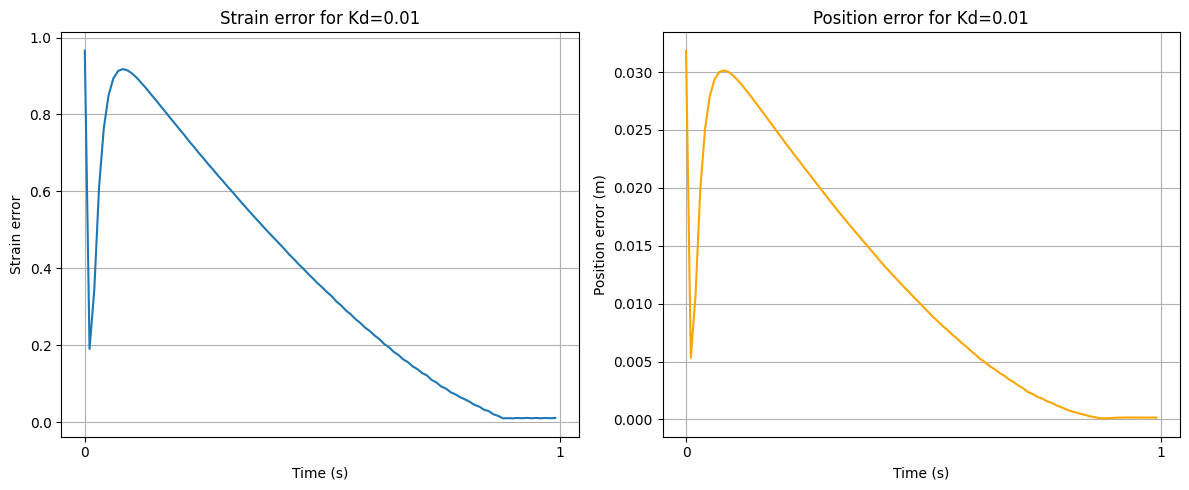

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# make the strain error and position error plots side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))   
ax1.plot(t, strain_errors)
ax1.set_title("Strain error for Kd={Kd}".format(Kd=Kd))
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Strain error")
ax1.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax1.grid(True)
ax2.plot(t, pos_errors, color='orange')
ax2.set_title("Position error for Kd={Kd}".format(Kd=Kd))
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Position error (m)")
ax2.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax2.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipykernel_32301/2076501774.py:8: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



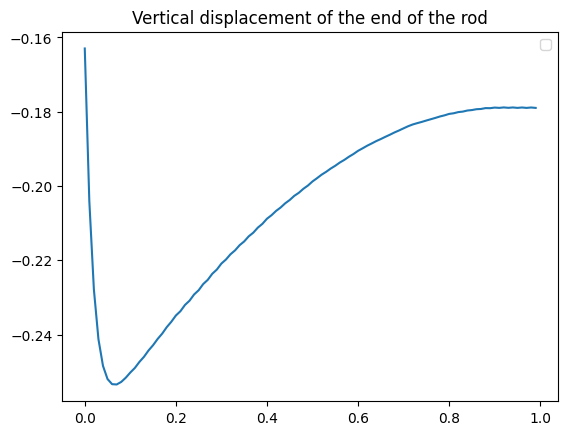

In [9]:
ax = plt.gca()
ax.ticklabel_format(style='plain', axis='y')

t = np.arange(0, robot.sim_params.total_time, robot.sim_params.dt)
plt.plot(t, qs[:, robot.end_node_dof_index-1])
#plt.plot(elastica['time'], elastica['position'][:, 2, -1], label='elastica')
plt.title("Vertical displacement of the end of the rod")
plt.legend()
plt.show()

In [10]:
# # save the final nodal configuration
# final_node_coordinates = qs[-1, :robot.end_node_dof_index].reshape(-1, 3)
# # save to csv for easier plotting in matlab
# np.savetxt('vertical_rod_n11_reference.csv', final_node_coordinates, delimiter=',')